# Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
%matplotlib inline

## Generating data set

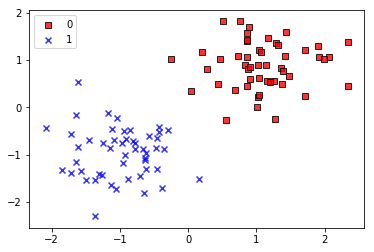

In [2]:
center=[[1,1],[-1,-1]]
data_size=50
data=[c+np.random.randn(data_size,2)*0.5 for c in center]
data=np.concatenate(data)
label = np.arange(2*data_size)//data_size
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
for i in range(2):
    plt.scatter(data[:,0][label==i],data[:,1][label==i],alpha=0.8,label=i,edgecolor='black',c=colors[i],marker=markers[i])
plt.legend();

## Function for visualization 

In [3]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.05):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.legend()
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## Logistic regression using scikit learn

C:\Users\takuya2262\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


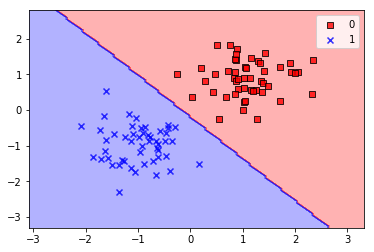

In [4]:
lr=LogisticRegression(C=100.0,random_state=1)
lr.fit(data,label)
plot_decision_regions(data,label,classifier=lr)

## Bayesian logistic regression

In [5]:
class BayesianLogisticRegression:
    def __init__(self,M,s,mu,max_iter=100,alpha=1):
        self.M=M   #number of basis functions
        self.s=s   #standard deviation of basis functions
        self.mu=mu #average of basis functions
        self.max_iter=max_iter
        self.alpha=alpha
    def gauss(self,x,mu):
        return np.exp(-(x-mu).T@np.linalg.inv(self.s)@(x-mu)/2)
    def gauss_vec(self,x,mu):
        gauss=[]
        for i in range(len(mu)):
            gauss.append(np.exp(-(x-mu[i]).T@np.linalg.inv(self.s)@(x-mu[i])/2))
        return gauss
    def design_matrix(self,X):
        gauss_function=np.zeros((len(X),self.M))
        for j in range(self.M):
            for i in range(len(X)):
                gauss_function[i,j]=self.gauss(X[i],self.mu[j])
        return gauss_function
    def sigmoid(self,x):
        return np.divide(1,1+np.exp(-x))
    def fit(self,X,t):
        Phi=self.design_matrix(X)
        self.w=np.random.randn(self.M)
        for i in range(self.max_iter):
            w_tmp=np.copy(self.w)
            y=self.predict_proba(X)
            gradE=Phi.T@(y-t)+self.alpha*self.w
            H=Phi.T@np.diag(y*(1-y))@Phi+self.alpha*np.identity(len(self.w))
            try:
                self.w=self.w-np.linalg.inv(H)@gradE
            except np.linalg.LinAlgError:
                break
            if np.allclose(self.w,w_tmp):
                break
        print('iteration number',i)
        y=self.predict_proba(X)
        gradE=Phi.T@(y-t)+self.alpha*self.w
        H=Phi.T@np.diag(y*(1-y))@Phi+self.alpha*np.identity(len(self.w))
        self.SN=np.linalg.inv(H)
        return self
    def predict_dist(self,X):
        Phi=self.design_matrix(X)
        mu_a=Phi.dot(self.w)
        sigma_a=np.sum(Phi.dot(self.SN) * Phi, axis=1)
        return self.sigmoid(mu_a / np.sqrt(1 + np.pi * sigma_a / 8))
    def predict_proba(self,X):
        Phi=self.design_matrix(X)
        y_vec=[]
        for j in range(len(X)):
            y=self.sigmoid(self.w@self.gauss_vec(X[j],self.mu))
            y_vec.append(y)
        return np.array(y_vec)
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
        

In [6]:
s=[[4,0],[0,4]]
mu=[[-1,-1],[1,1],[-1,1],[1,-1]]
M=len(mu)
blr=BayesianLogisticRegression(M,s,mu)
blr.fit(data,label)
label_test=blr.predict(data)

iteration number 6


In [7]:
def plot_decision_regions_prob(X, y, classifier, test_idx=None, resolution=0.05):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict_dist(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3,levels=np.linspace(0,1,5),cmap="bwr_r")
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.colorbar()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.legend()
    plt.title('Predictive distribution')
  

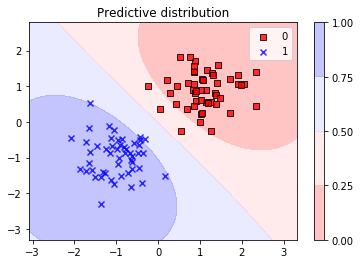

In [8]:
plot_decision_regions_prob(data,label,classifier=blr)